<a href="https://colab.research.google.com/github/auto-d/vision-mapping/blob/main/viz_map.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Vision Mapping

[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/auto-d/vision-mapping/blob/main/viz_map.ipynb)

This notebook explores the use of class activation maps (CAM) to help explain model classifications of security camera stills. The base model used for classification is [ResNet50](https://github.com/pytorch/vision/blob/main/torchvision/models/resnet.py).

## Dependencies

We'll make use of the python `grad-cam` library due to its superior documentation. Ensure prerequisities are installed.

In [49]:
!pip install grad-cam

In [67]:
!mkdir data
!wget https://github.com/auto-d/vision-mapping/raw/main/data/imagenet_2.jpg -q -O data/imagenet_2.jpg
!wget https://github.com/auto-d/vision-mapping/raw/main/data/porch.png -q -O data/porch.png
!wget https://github.com/auto-d/vision-mapping/raw/main/data/sidewalk.png -q -O data/sidewalk.png
!wget https://github.com/auto-d/vision-mapping/raw/main/data/warehouse.png -q -O data/warehouse.png
!wget https://github.com/auto-d/vision-mapping/raw/main/data/garage.png -q -O data/garage.png
!wget https://github.com/auto-d/vision-mapping/raw/main/data/patio.png -q -O data/patio.png

mkdir: cannot create directory ‘data’: File exists


Helpers to identify presence/absence of GPUs for batch testing.

In [68]:
import os
import torch

In [69]:
def check_acceleration():
    """
    Check for acceleration/GPU and return an indicator
    """
    device = None
    gpus = torch.cuda.is_available()
    if gpus:
        device = "cuda"
        print("GPU acceleration appears to be available!")
        for device in range(1, torch.cuda.device_count()):
            print(f"Found {torch.cuda.get_device_name(device)}")
    else:
        device = "cpu"
        print("GPU resources not found, defaulting to CPU.")

    return device

In [70]:
device = check_acceleration()

GPU resources not found, defaulting to CPU.


In [71]:
def inspect_model_file(path, device):
    """
    Inspect a torch .pth
    """
    if not os.path.exists(path):
        raise FileNotFoundError(f"Model file {path} doesn't exist!")
    kwargs = {} if device == "cuda" else { "map_location": torch.device('cpu') }
    data = torch.load(path, **kwargs)
    print(type(data))
    for k, v in data.items():
        print(k, v.shape)

## Resnet

Resnet is a venerable image classifier and will serve as our explainability target. We'll use the 50-layer variant with the architecture called out below.

![resnet50](https://github.com/auto-d/vision-mapping/blob/main/resnet50.png?raw=1)

In [72]:
import cv2
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
from torch.nn.functional import softmax, interpolate
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.io.image import read_image
from torchvision.transforms.functional import normalize, resize, to_pil_image

We'll pass a test image through to ensure the model is correctly loading and predicting. Note this Resnet version was applied to ImageNet and thus emits logics for the the 1000 ImageNet classes it learned during training.

In [73]:
sample_image = "data/imagenet_2.jpg"
img = read_image(sample_image)

In [74]:
def torch_to_cv2(img):
    """
    Torchvision image (c, h, w) -> OpenCV image (h,w,c)
    """
    return img.permute(1, 2, 0)

def cv2_to_torch(img):
    """
    OpenCV image (h,w,c) -> Torchvision image (c, h, w)
    """
    return img.permute(2, 0, 1)


In [75]:
def print_resnet_topk(probs, k=5):

    classes = ResNet50_Weights.DEFAULT.meta["categories"]

    topk = torch.topk(probs, k)
    print("Top predictions, in descending order:")
    for prob, ix in zip(topk[0], topk[1]):
        print(f"- {classes[ix]} (label={ix}, p={prob:.3f})")

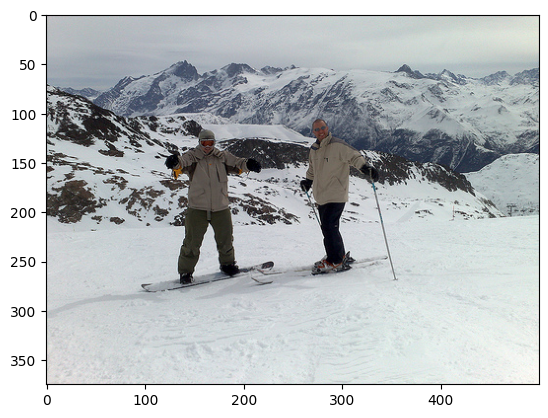

In [76]:
_ = plt.imshow(torch_to_cv2(img))

Scale the image to our Resnet input dimensions and obtain logits.

In [77]:
img_scaled = img / 255.
img_square = resize(img_scaled, (224,224))
input_tensor = normalize(
    tensor=img_square,
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225])

In [78]:
img_square.shape

torch.Size([3, 224, 224])

In [79]:
model = resnet50(pretrained=True).eval()
logits = model(input_tensor.unsqueeze(0))

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Now obtain probabilities and top predicted classes.

In [80]:
def print_resnet_topk(out, k=5):
    """
    Emit predictions based on provided probabilities for the 1000 imagenet classes that resnet
    predicts.
    """

    # Class mapping from https://docs.pytorch.org/vision/main/models.html
    classes = ResNet50_Weights.DEFAULT.meta["categories"]

    probs = torch.nn.functional.softmax(out, dim=1).detach().flatten()
    topk = torch.topk(probs, k)
    print("Top predictions, in descending order:")
    for prob, ix in zip(topk[0], topk[1]):
        print(f"- {classes[ix]} (label={ix}, p={prob:.3f})")

In [81]:
print_resnet_topk(logits)

Top predictions, in descending order:
- ski (label=795, p=0.923)
- alp (label=970, p=0.076)
- shovel (label=792, p=0.000)
- dogsled (label=537, p=0.000)
- mountain tent (label=672, p=0.000)


The model correctly classifies this as ski scene, though resnet only gets one vote here. There are other, distant classes that are also not entirely inappropriate.

## Application: Security Camera Footage Classification

One of us (okay me) has this half-baked idea of using resnet to serve as a speedy classifier of video stills from security camera streams. We've created a custom dataset of stills from a video camera feed and we'll experiment on those.

In [82]:
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image
from pytorch_grad_cam import GradCAM

In [83]:
def prep_image(path):
    """
    Load an image off disk, normalize it and return a tensor representing in the torchvision
    format: (c, h, w)
    """
    rgb = cv2.imread(path, 1)[:, :, ::-1]
    rgb = np.float32(rgb) / 255
    tensor = preprocess_image(
        rgb,
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225])

    return rgb, tensor

Load an image, obtinaing a tensor with our normalized pixel values to pass to torch in the process. Here we see a very typical scene, with a delivery in progress to this porch.

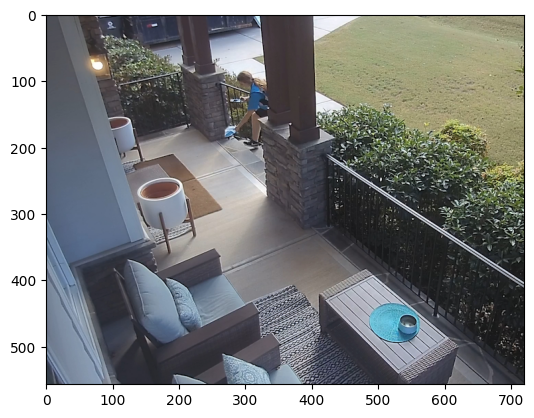

In [84]:
img, input_tensor = prep_image("./data/porch.png")
plt.imshow(img)

In [85]:
logits = model(input_tensor)
print_resnet_topk(logits)

Top predictions, in descending order:
- patio (label=706, p=0.057)
- bannister (label=421, p=0.033)
- sliding door (label=799, p=0.019)
- solar dish (label=807, p=0.015)
- ashcan (label=412, p=0.012)


Okay, so our application is already looking a little dicey. Here we have a partially occluded Amazon delivery person in the frame, but Resnet is more interested in the railing, and thinks the pots or perhaps the mat on the table is a solar dish. But, in defense of the model, we're probably pretty far outside the distribution of ImageNet training images, which often had a single prominent item in the image. Also in defense of the model, those probabilities are pretty low. It is clearly perplexed.

We'll detour into the explainability topic before returning to more experimentation on security stills.

### Explaining w/ GradCAM

GradCAM is a method for enriching classifications based on the visual features that underpinned those classifications. The technique is outlined in [this paper](https://arxiv.org/abs/1610.02391). GradCAM ties the gradients of one or more feature maps to the network's prediction, giving us an appreciation for which pixels had outsize bearing on the class prediction. Below is a diagram from the original paper that illustrates how filter gradients are joined with class predictions and the notional applications.

![gradcam diagram](https://github.com/auto-d/vision-mapping/blob/main/doc/gradcam.png?raw=1)

As illustrated in the above diagram, GradCAM needs to inspect (hook) a layer in the network to extract gradients from. Here we look at the output of the last layer of feature maps in the model.

In [86]:
target_layers = model.layer4

We instantiate the GradCAM helper, passing our target model and a reference to the layer we want to mine gradients from. Then retrieve an activation map given a specific example.

In [87]:
cam = GradCAM(model=model, target_layers=target_layers)
gray_cam = cam(
    input_tensor=input_tensor,
    targets=None,
    aug_smooth=False,
    eigen_smooth=False)[0, :]

Now overlay a heatmap of the activated pixels, scaled back up to the original image resolution so we can try to make sense of the activations and in turn, the prediction.

In [88]:
cam_image = show_cam_on_image(img, gray_cam, use_rgb=True)

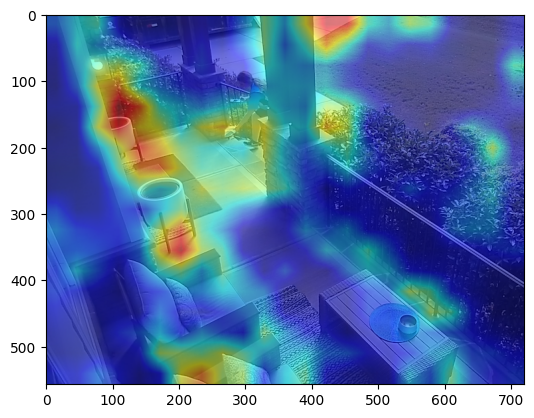

In [89]:
plt.imshow(cam_image)

We get some hints as to the models confusion here. In lieu of a single object activating, we have mild activations all over the image. The rationale for the tenuous classification of `bannister` or `satellite dish` become apparent, with the railing and the pot's legs getting some attention.

Let's make this more repeatable and validate the processing on our original test image.

In [90]:
def predict_and_explain(model, target, image_path, variant=GradCAM, show=True):
    """
    Classify the image provided and then explain said prediction with a GradCAM variation
    """
    img, input_tensor = prep_image(image_path)

    logits = model(input_tensor)
    print_resnet_topk(logits)

    cam = variant(model=model, target_layers=target)
    gray_cam = cam(
        input_tensor=input_tensor,
        targets=None,
        aug_smooth=False,
        eigen_smooth=False)[0, :]

    cam_image = show_cam_on_image(img, gray_cam, use_rgb=True)

    if show:
        plt.imshow(cam_image)
        plt.title(f"GradCAM-based activations")

    return cam_image

Top predictions, in descending order:
- ski (label=795, p=0.749)
- alp (label=970, p=0.168)
- dogsled (label=537, p=0.020)
- mountain tent (label=672, p=0.011)
- snowmobile (label=802, p=0.009)


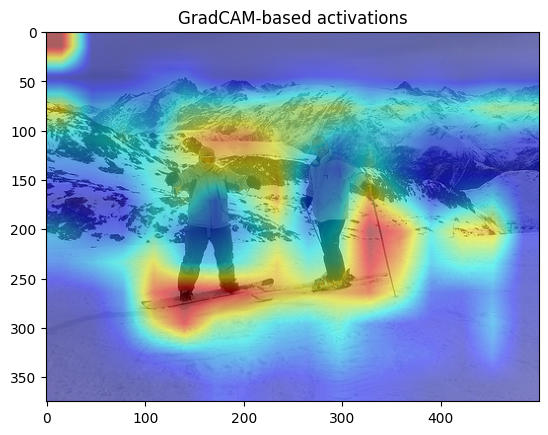

In [91]:
_ = predict_and_explain(model, target_layers, sample_image)

This is pretty convincing, we have some highly intuitive reflections of the `ski` label illuminated here by the gradient-based activation map. The skiier's pole, the snowboard, the mountains and the snow are all getting in on the prediction. Interestingly we have what feels like a spurious region of actviation in the upper left, where no appreciable variation in pixel color exists.

#### XGradCAM

As laid out in [this paper](https://arxiv.org/abs/2008.02312), there is some concern over the rigor supporting the GradCAM technique. The paper introduces class-specific weightings and claims a higher sensitivity and better faithfulness to the classification.

In [92]:
from pytorch_grad_cam import XGradCAM

Top predictions, in descending order:
- ski (label=795, p=0.749)
- alp (label=970, p=0.168)
- dogsled (label=537, p=0.020)
- mountain tent (label=672, p=0.011)
- snowmobile (label=802, p=0.009)


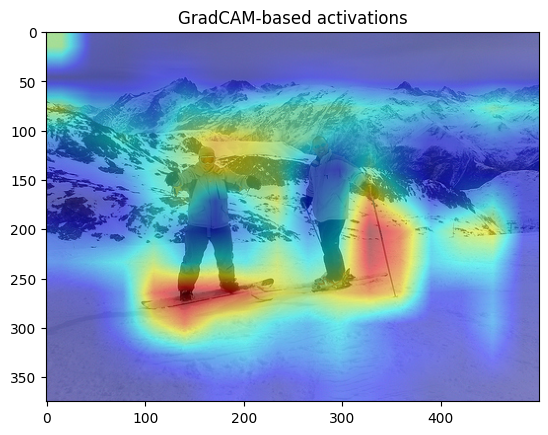

In [93]:
_ = predict_and_explain(model, target_layers, sample_image, XGradCAM)

The implementation of this method is quite close to GradCAM and while some regions appear less intensively attributed, the overall pattern is effectively the same. This is perhaps due to the strong probability associated with the classification. If were to introduce a more perplexing scene to the model, we may see decrease in the associated activation intensity. We also note the persistence of the activation in the upper left corner.

### HiResCAM

In [this paper](https://arxiv.org/abs/2011.08891), Draelos and Carin call attention to the fact that GradCAM can attribute areas of the source image that were not actually used in the prediction. This, as with the XGradCam  variation, is also a charge levied at the averaging mechanism in GradCam. The authors propose HiResCAM as an alternative, which is also class-specific and is guaranteed to highlight only the regions used to make each prediction.

In [94]:
from pytorch_grad_cam import HiResCAM

Top predictions, in descending order:
- ski (label=795, p=0.749)
- alp (label=970, p=0.168)
- dogsled (label=537, p=0.020)
- mountain tent (label=672, p=0.011)
- snowmobile (label=802, p=0.009)


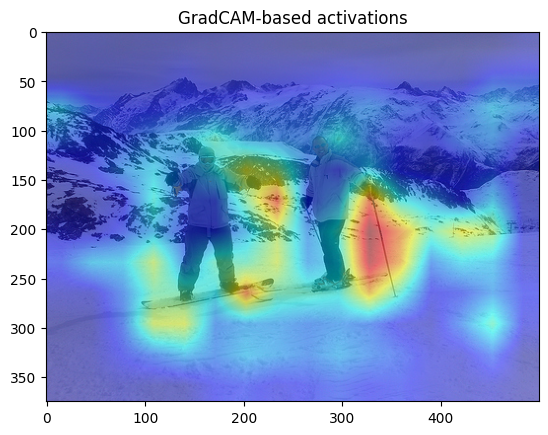

In [95]:
_ = predict_and_explain(model, target_layers, sample_image, HiResCAM)

We see a similar pattern of activations driving the classiciation with HiResCAM. Though, perhaps lending credence to the authors concern over false activations, we see the phantom activation in the upper left region disappear entirely.

### Test Images

We now return to apply GradCAM and friends to our security application.  We have a small security camera dataset that is shown below.

In [96]:
samples = [
    './data/patio.png',
    './data/garage.png',
    './data/sidewalk.png',
    './data/warehouse.png',
    './data/porch.png',
]

cams = [ GradCAM, XGradCAM, HiResCAM]

In [97]:
def predict(model, image_path):
    """
    Get predictions for provided image
    """
    _, input_tensor = prep_image(image_path)

    logits = model(input_tensor)
    print_resnet_topk(logits)

def explain(model, target, image_path, variant=GradCAM, show=True):
    """
    Explain predictions with a GradCAM variation
    """
    img, input_tensor = prep_image(image_path)

    cam = variant(model=model, target_layers=target)
    gray_cam = cam(
        input_tensor=input_tensor,
        targets=None,
        aug_smooth=False,
        eigen_smooth=False)[0, :]

    cam_image = show_cam_on_image(img, gray_cam, use_rgb=True)

    if show:
        plt.imshow(cam_image)

    return cam_image

#### 1 - The Patio

In our first scene, we have a person clearly visible.

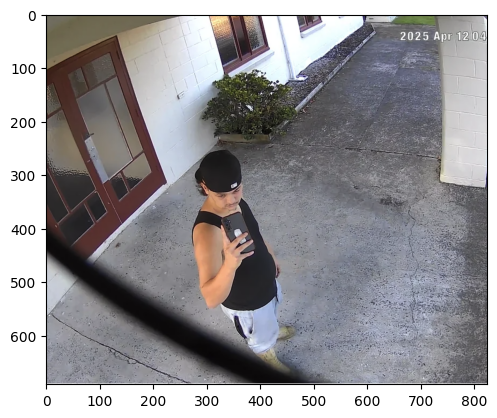

In [98]:
img, _ = prep_image(samples[0])
plt.imshow(img)

In [99]:
predict(model, samples[0])

Top predictions, in descending order:
- doormat (label=539, p=0.024)
- window screen (label=904, p=0.021)
- bannister (label=421, p=0.018)
- bathtub (label=435, p=0.015)
- prison (label=743, p=0.015)


We again see a perplexed model, with a wide distribution of probabilities.

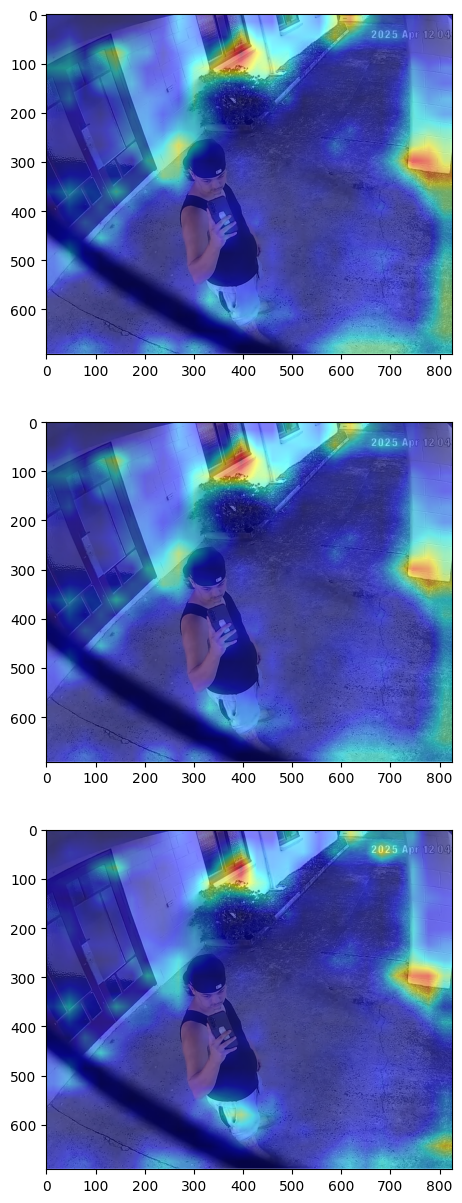

In [100]:
fig, axs = plt.subplots(len(cams), 1, figsize=(6, 5*len(cams)))
for i, cam in enumerate(cams):
    cam_img = explain(model, target_layers, samples[0], cam)
    axs[i].imshow(cam_img)

All of our activation maps are fixated on the window, and the contrast at the corner of the wall (pillar?). This perhaps is what tilts the prediction toward bannister, doormat, jail. Oddly, we see no activations around the human standing in plain sight. Looking at the images of people in ImageNet, there's a lot of frontal pictures, not so many oblique or partially obscured. Whatever ResNet learned to classify people on is clearly not this type of scene.

#### 2 - The Garage

In our second scene, we have some inanimate objects, notably a garage, a light pole and some trees. These are warped pretty badly by a fisheye lens. Let's see what happens

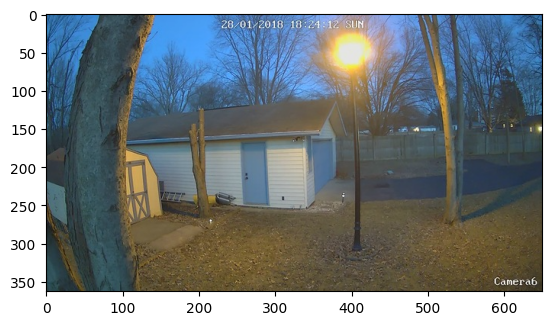

In [101]:
img, _ = prep_image(samples[1])
plt.imshow(img)

In [102]:
predict(model, samples[1])

Top predictions, in descending order:
- pole (label=733, p=0.099)
- mobile home (label=660, p=0.081)
- lakeside (label=975, p=0.064)
- flagpole (label=557, p=0.042)
- boathouse (label=449, p=0.039)


I wouldn't call this a confident prediction. The proababilities are more concentrated than previous, but this is another problematic situation. Pole is technically correct, though again the probabilities are pretty unconvincing.

This is also another opportunity to reflect on how bad of an idea it seems to have been to use something like an ImageNet-trained model to look at real-world video stills.

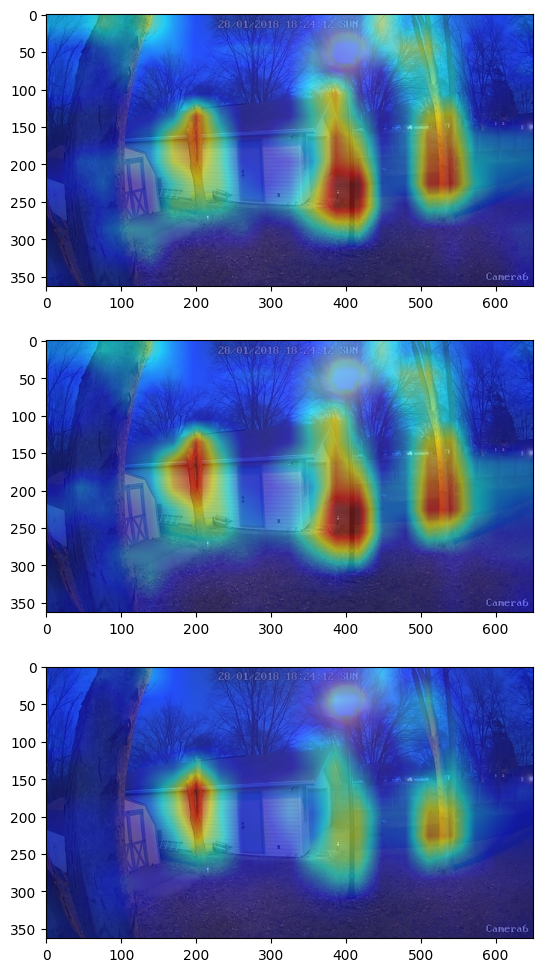

In [103]:
fig, axs = plt.subplots(len(cams), 1, figsize=(7, 4*len(cams)))
for i, cam in enumerate(cams):
    cam_img = explain(model, target_layers, samples[1], cam)
    axs[i].imshow(cam_img)

Again, I think we have something like agreement on the activation maps. We have a tree, a tree stump and a pole dominating the features of interest.

#### 3 - The Sidewalk

Here we have a woman holding a paper on a sidewalk.

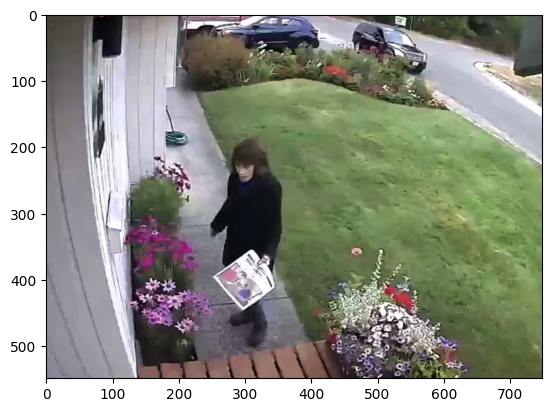

In [104]:
img, _ = prep_image(samples[2])
plt.imshow(img)

In [105]:
predict(model, samples[2])

Top predictions, in descending order:
- solar dish (label=807, p=0.023)
- window screen (label=904, p=0.018)
- mobile home (label=660, p=0.013)
- limousine (label=627, p=0.011)
- ashcan (label=412, p=0.008)


I'm not getting solar dish vibes here, as the model predicts. Let's see what's activating.

In [ ]:
fig, axs = plt.subplots(len(cams), 1, figsize=(6, 5*len(cams)))
for i, cam in enumerate(cams):
    cam_img = explain(model, target_layers, samples[2], cam)
    axs[i].imshow(cam_img)

Another situation that is difficult to explain. We have zero activation on the indiviudal, and a lot of interest around what look like innocuous features or intersecting lines. We are looking at the latest/deepest convolutional layer. It's tempting to conclude that the residual connections in Resnet are feeding lower level features to the fully-connected layers, creating a disconnect between the classification and the activation map. However we have seen anecdotal evidence that the shapes highlighted by the activation maps are precisely the types of objects Resnet is nominating.

#### 4 - The Warehouse

We next look at a warehouse seen.

In [ ]:
img, _ = prep_image(samples[3])
plt.imshow(img)

In [ ]:
predict(model, samples[4])

A pattern is starting to emerge here, a confused resnet seems have a bias toward classifying things as window screens, ashcans, solar dishes.

In [ ]:
fig, axs = plt.subplots(len(cams), 1, figsize=(6, 6*len(cams)))
for i, cam in enumerate(cams):
    cam_img = explain(model, target_layers, samples[3], cam)
    axs[i].imshow(cam_img)

Another puzzling lack of activation on human parts.

#### 5 - The Porch

We end where we started, with a delivery on the front porch. Will the more rigorous GradCAM variants improve our understanding of what's going on?

In [ ]:
img, _ = prep_image(samples[4])
plt.imshow(img)

In [ ]:
predict(model, samples[4])

No change, unsurprisingly.

In [ ]:
fig, axs = plt.subplots(len(cams), 1, figsize=(6, 6*len(cams)))
for i, cam in enumerate(cams):
    cam_img = explain(model, target_layers, samples[4], cam)
    axs[i].imshow(cam_img)

We again see the railing highlighted, perhaps corresponding to the bannister classification. Same for the pot with the legs, which might be our satellite dish motivator. Overall the sporadic activations don't lend much comfort that the activations are keyed particularly on anything.

### Conclusion

Resnet may perform well on the ImageNet challenge, but its application here to video stills is unimpressive. Overall grade is an F+, with some credit for classifying a pole in the garage scene. The presence of the activation maps made a significant difference in our ability to make sense of even low probability classes. CAM is a useful technique that is probably more interesting when paired with a model that is predicting on in-distribution examples.